> __Purpose:__ This NB visualizes the results of the full study for DynamicMomonaNet. Will be adding different feature engineerings here.

In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42) 

from agglo_model_clust import *
from cluster_acc_viz_funcs import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *
from full_study_funcs import *  # Replace?
from revamped_model_classes import *
from hyperparam_tuned_configs import *

import os
cwd = os.getcwd()
print("Current Working Directory: ", cwd)


Current Working Directory:  c:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj


In [2]:
MODEL_STR = "DynamicMomonaNet"
MY_CONFIG = DynamicMomonaNet_config
SAVE_FIGS = False
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Train/test user split: 24/8
## Is this part of config now? The split number?
## No it is hardcoded below...



In [3]:
expdef_df = load_expdef_gestures(feateng_method=MY_CONFIG["feature_engr"])

print(expdef_df.shape)
expdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P102,pan,1,"[[-1.5563754649803136, -0.17884213655174025, -...",5,6
1,P102,pan,2,"[[-2.0947934429427453, -0.18463052523258242, -...",5,6
2,P102,pan,3,"[[-1.47972105766918, -0.14489860670069354, -0....",5,6
3,P102,pan,4,"[[-1.4504054170702374, -0.18478424991674858, -...",5,6
4,P102,pan,5,"[[-1.809093742221055, -0.21738573258562152, -0...",5,6


In [4]:
all_participants = expdef_df['Participant'].unique()
# Shuffle the participants
np.random.shuffle(all_participants)
# Split into two groups
#train_participants = all_participants[:24]  # First 24 participants
test_participants = all_participants[24:]  # Remaining 8 participants

In [5]:
# Prepare data
data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=8, finetuning_trials_per_gesture=3,
)

In [6]:
features_df = pd.DataFrame(data_splits['train']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
train_df['Cluster_ID'] = label_encoder.fit_transform(train_df['participant_ids'])

features_df = pd.DataFrame(data_splits['intra_subject_test']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
test_df = pd.concat([features_df, pd.Series(data_splits['intra_subject_test']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['intra_subject_test']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
test_df['Cluster_ID'] = label_encoder.fit_transform(test_df['participant_ids'])

# ENTIRELY WITHHOLDING CROSS CLUSTER DATASET (NOVEL TEST SUBJECTS) FOR NOW. 
# TODO: Pull this from other file
#test_df
#features_df = pd.DataFrame(data_splits['train']['features'])
## Create a new column 'features' that contains all 80 columns as lists
#features_df['features'] = features_df.apply(lambda row: row.tolist(), axis=1)
## Keep only the new combined column
#features_df = features_df[['features']]
## Combine with labels and participant_ids into a single DataFrame
#train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)

In [7]:
data_dfs_dict = {'train':train_df, 'test':test_df}

# Need to update Cluster_ID col at the end of each round, for both dfs

In [8]:
train_df.head()

,feature,Gesture_Encoded,participant_ids,Cluster_ID
0,"[-0.0027802179541289163, 0.02027887161659458, ...",0,P008,2
1,"[0.025828357613286584, -0.2054508606041052, -0...",0,P008,2
2,"[-0.008017313504683203, -0.034065450382886955,...",0,P008,2
3,"[-0.006185951199900441, 0.0685550699295961, -0...",0,P008,2
4,"[-0.6524104326693295, -0.29162077883122917, -0...",0,P008,2


In [9]:
# Load the CLUSTERING RESULTS DATA
with open('C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\results\\clustering_models\\20250210_2137\\20250210_2137_DynamicMomonaNet_agglo_merge_res.pkl', 'rb') as f:
    merge_log = pickle.load(f)
    intra_cluster_performance = pickle.load(f)
    cross_cluster_performance = pickle.load(f)
    nested_clus_model_dict = pickle.load(f)

print("Data has been loaded successfully!")

Data has been loaded successfully!


# Finetuning Process

In [10]:
# This needs to be formalized... ie how we pick which iter to use for the cutpoint

cluster_lst = list(nested_clus_model_dict['Iter18'].keys())
print("Cluster list:")
print(cluster_lst)

Cluster list:
[31, 35, 38, 39, 40, 41]


In [11]:
#full_path = os.path.join("C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\models\\hyperparam_tuning\\20250130_2003", 'originalHyperparamTuning_pretrained_DynamicMomonaNet_model.pth')
#full_path = os.path.join("C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\models\\hyperparam_tuning\\20250205_2115", '80configFeb5_pretrained_DynamicMomomaNet_model.pth')

# With new ES code:
full_path = os.path.join("C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\models\\20250211_1202", 'pretrained_DynamicMomonaNet_model.pth')

print("Full Path:", full_path)
# Load the pretrained model
pretrained_generic_model = select_model(MODEL_STR, MY_CONFIG)
pretrained_generic_model.load_state_dict(torch.load(full_path))

Full Path: C:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj\models\20250211_1202\pretrained_DynamicMomonaNet_model.pth


<All keys matched successfully>

In [12]:
cluster_lst = list(nested_clus_model_dict['Iter18'].keys())
print("Cluster list:")
print(cluster_lst)
print()
print("Cluster 41 model:")
print(nested_clus_model_dict['Iter18'][41])

Cluster list:
[31, 35, 38, 39, 40, 41]

Cluster 41 model:
DynamicMomonaNet(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
      (1): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
      (1): Dropout(p=0.3, inplace=False)
    )
  )
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dense_cnn_lstm): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(128, 8, batch_first=True)
  (fc_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=464, out_features=128, bias=True)
      (1): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Dropout(p=0.3, inplace=False)
    )
  )
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU

In [13]:
# Prepare data
one_trial_data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=1, finetuning_trials_per_gesture=1,
)

three_trial_data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=3, finetuning_trials_per_gesture=3,
)

five_trial_data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=5, finetuning_trials_per_gesture=5,
)

In [14]:
#novel_participant_ft_data = finetuning_datasplits['novel_trainFT']
#novel_participant_test_data = finetuning_datasplits['cross_subject_test']
#novel_pids = np.unique(finetuning_datasplits['novel_trainFT']['participant_ids'])
#novel_pid_clus_asgn_data = cluster_assgnmt_data_splits['novel_trainFT']

np.unique(three_trial_data_splits['novel_trainFT']['participant_ids'])

array(['P006', 'P011', 'P108', 'P109', 'P112', 'P118', 'P124', 'P125'],
      dtype='<U4')

## FEW-SHOT: 5 trials for training (local+FT) and 5 trials for cluster assignment

In [15]:
data_dict_5_5 = full_comparison_run(five_trial_data_splits, five_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                        nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')

PID P006, 0/8
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00015: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00021: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00029: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00035: reducing learning rate of group 0 to 1.0000e-08.
Epoch 00029: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00035: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00041: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00047: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00053: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00059: reducing learning rate of group 0 to 1.0000e-08.
Cluster 31 had the highest accuracy (0.22)
Epoch 00016: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00033: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00039: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00045: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00051: 

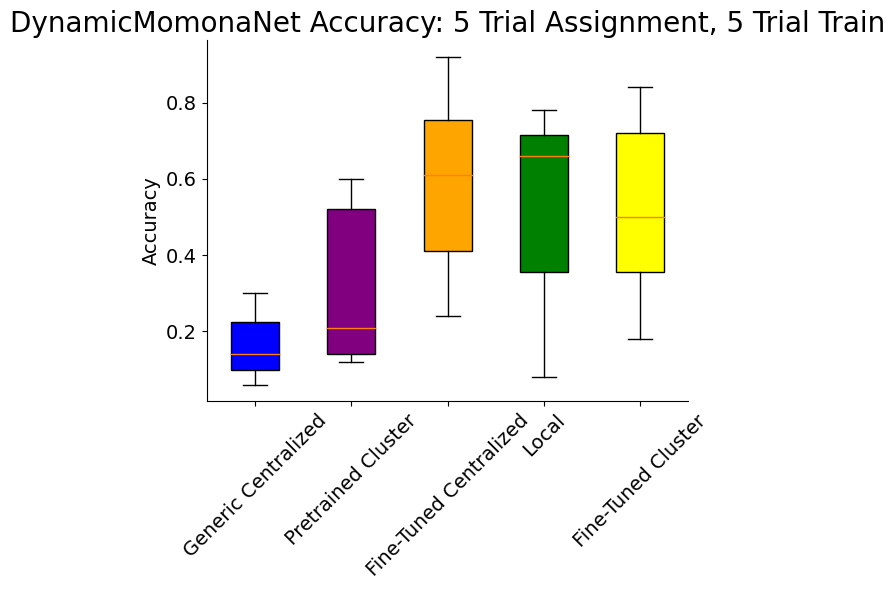

In [16]:
plot_model_acc_boxplots(data_dict_5_5, my_title=f"{MODEL_STR} Accuracy: 5 Trial Assignment, 5 Trial Train", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_5TA_5TT")


## ONE-SHOT: 1 trial for training (local+FT) and cluster assignment

In [17]:
data_dict_1_1 = full_comparison_run(one_trial_data_splits, one_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                        nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')

PID P006, 0/8
Epoch 00019: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00025: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00037: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00043: reducing learning rate of group 0 to 1.0000e-08.
Epoch 00029: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00035: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00041: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00047: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00053: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00059: reducing learning rate of group 0 to 1.0000e-08.
Cluster 38 had the highest accuracy (0.3)
Epoch 00025: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00037: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00043: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00049: r

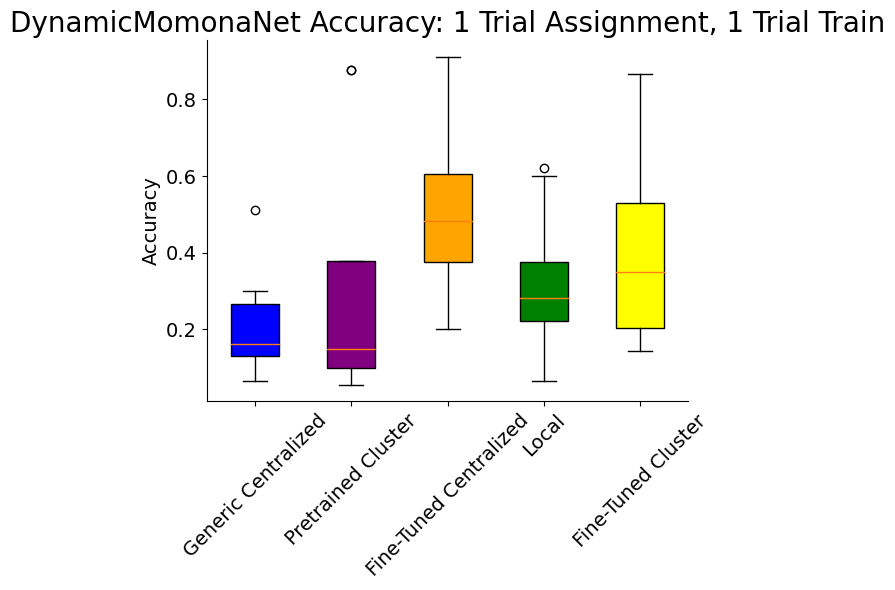

In [18]:
plot_model_acc_boxplots(data_dict_1_1, my_title=f"{MODEL_STR} Accuracy: 1 Trial Assignment, 1 Trial Train", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_1TA_1TT")